In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import os
import random
import wandb
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.models as models

In [2]:
# Poisson Image Editing function for synthetic anomaly creation
def poisson_edit(source, destination, mask):
    center = (destination.shape[1] // 2, destination.shape[0] // 2)
    try:
        # Ensure dimensions match
        if source.shape != destination.shape or source.shape[:2] != mask.shape[:2]:
            raise ValueError("Source, destination, and mask dimensions must match.")
        if np.sum(mask) == 0:
            raise ValueError("Mask is empty, skipping Poisson blending.")
        blended = cv2.seamlessClone(source, destination, mask, center, cv2.NORMAL_CLONE)
    except (cv2.error, ValueError) as e:
        print(f"Error during Poisson editing: {e}. Using the original destination image.")
        blended = destination
    return blended

In [3]:
# Custom Dataset class with Poisson editing for synthetic anomalies
class MVTecNSADataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_paths = []
        for root, _, files in os.walk(os.path.join(root_dir, split)):
            for fname in files:
                if fname.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root, fname))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if idx >= len(self.image_paths):
            raise IndexError("Index out of range for dataset.")
        
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Image at path {img_path} could not be loaded.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        
        # Apply Poisson image editing to create synthetic anomalies
        if self.split == "train":
            source_idx = random.randint(0, len(self.image_paths) - 1)
            source_img_path = self.image_paths[source_idx]
            source_image = cv2.imread(source_img_path)
            if source_image is None:
                raise ValueError(f"Source image at path {source_img_path} could not be loaded.")
            source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
            source_image = cv2.resize(source_image, (256, 256))

            mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
            h, w = mask.shape
            top_left = (random.randint(0, w // 2), random.randint(0, h // 2))
            bottom_right = (random.randint(w // 2, w), random.randint(h // 2, h))
            mask[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = 255

            # Ensure mask is valid
            if np.sum(mask) > 0:
                image = poisson_edit(source_image, image, mask)
            else:
                print("Generated mask is empty. Using the original image without editing.")
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        
        return image, 0  # Label 0 for normal data

In [4]:
# Visualize dataset samples
# Expected output: Displays images from the dataset
# If there are any issues with image loading, an error message is printed
def visualize_dataset_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        try:
            image, _ = dataset[i]
            image = image.permute(1, 2, 0).numpy()
            axes[i].imshow(image)
            axes[i].axis('off')
        except (ValueError, IndexError) as e:
            print(e)
            continue
    plt.show()


Total number of images in the dataset: 209


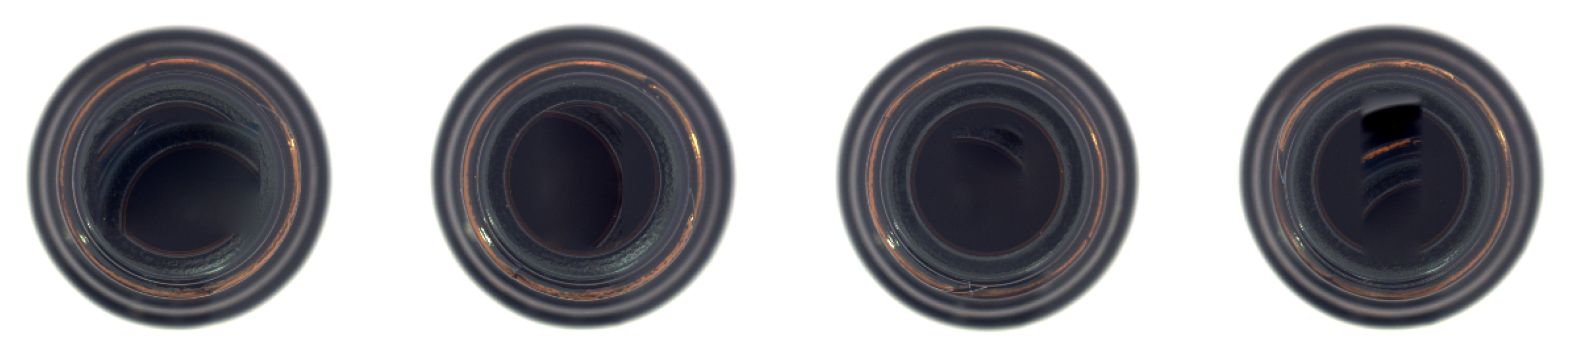

In [5]:
# Analyze dataset
# Expected output: Total number of images in the dataset and visualizes samples
def analyze_dataset(dataset):
    num_images = len(dataset)
    print(f"Total number of images in the dataset: {num_images}")
    
    # Visualizing samples
    visualize_dataset_samples(dataset, num_samples=4)


analyze_dataset(MVTecNSADataset("./datasets/mvtec/bottle/", split="train"))

In [6]:
# Model class: ResNet Encoder-Decoder with TransposeBasicBlock
# Expected output: Initializing ResNet-based encoder-decoder model
class TransposeBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransposeBasicBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=2, output_padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        # Perform upsampling path
        upsampled = self.upsample(x)

        return self.relu(out + upsampled)

class ResNetEncDec(nn.Module):
    def __init__(self):
        super(ResNetEncDec, self).__init__()

        # Encoder: Using ResNet layers up to layer4
        resnet = models.resnet18(pretrained=True)
        
        # Encoder layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # NIN layer (512 -> 256 -> 128)
        self.nin = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True)
        )

        # Decoder (TransposeBasicBlock layers)
        self.uplayer1 = TransposeBasicBlock(128, 64)
        self.uplayer2 = TransposeBasicBlock(64, 32)
        self.uplayer3 = TransposeBasicBlock(32, 16)

        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2.0, mode='bilinear')

        # Final conv layer
        self.convtranspose1 = nn.ConvTranspose2d(16, 3, kernel_size=7, stride=2, padding=3, output_padding=1, bias=False)

        # Final activation (Identity in this case)
        self.final_activation = nn.Identity()

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # NIN Layer
        x = self.nin(x)

        # Decoder layers
        x = self.uplayer1(x)
        x = self.uplayer2(x)
        x = self.uplayer3(x)

        # Upsample
        x = self.upsample(x)

        # Final convolution
        x = self.convtranspose1(x)

        # Final activation (here it's Identity)
        x = self.final_activation(x)

        return x

In [7]:
# Initialize Weights and Biases (wandb)
wandb.init(project="nsa-mvtec", entity="sameerhashmi1995")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sameerhashmi1995. Use `wandb login --relogin` to force relogin


In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
# Load the MVTec dataset with NSA synthetic anomalies
# Expected output: Loads training and validation datasets from the given directory
data_dir = "./datasets/mvtec/bottle/"  
train_dataset = MVTecNSADataset(data_dir, split="train")
val_dataset = MVTecNSADataset(data_dir, split="test")

In [10]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [11]:
# Initialize the ResNetEncDec model
model = ResNetEncDec().to(device)
model

/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetEncDec(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [12]:
# optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [13]:
# Training function
# Expected output: Trains the model for one epoch and returns the average loss
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, _ in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        # Print shapes for debugging
        print(f"Input shape: {images.shape}, Output shape: {outputs.shape}")
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [14]:
# Validation function
# Expected output: Evaluates the model on the validation set and returns the average loss
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in tqdm(loader, desc="Validation", leave=False):
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
    return total_loss / len(loader)

In [26]:
# Full training function with tqdm
# Expected output: Trains the model for the specified number of epochs
# wandb for logging metrics
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=50):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        # Training
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Validation
        val_loss = validate_epoch(model, val_loader, criterion, device)
        
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss
        })
        
        # Save the model checkpoint if it's the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_resnet_encdec.pth")
        
        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [16]:
# Training model
train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=50)

Epoch [1/50]


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  14%|█▍        | 2/14 [00:02<00:14,  1.19s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  29%|██▊       | 4/14 [00:03<00:04,  2.06it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  43%|████▎     | 6/14 [00:03<00:02,  3.42it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  57%|█████▋    | 8/14 [00:03<00:01,  4.71it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:01,  3.13it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  4.49it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  3.27it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.5052, Val Loss: 0.3818
Epoch [2/50]


Training:   7%|▋         | 1/14 [00:01<00:20,  1.58s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.11it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.87it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.14it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.29it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.59it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.92it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.3221, Val Loss: 0.2801
Epoch [3/50]


Training:   7%|▋         | 1/14 [00:01<00:20,  1.61s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.08it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.01it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.29it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.27it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.54it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.2180, Val Loss: 0.1992
Epoch [4/50]


Training:   7%|▋         | 1/14 [00:01<00:20,  1.55s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.11it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.85it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.04it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.23it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.49it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.97it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.1495, Val Loss: 0.1382
Epoch [5/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.52s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.21it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.02it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.29it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.32it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.58it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.1033, Val Loss: 0.0954
Epoch [6/50]


Training:   7%|▋         | 1/14 [00:01<00:20,  1.56s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.17it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.96it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.26it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.03it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.26it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0727, Val Loss: 0.0681
Epoch [7/50]


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Error during Poisson editing: OpenCV(4.9.0) /io/opencv/modules/core/src/matrix_wrap.cpp:1667: error: (-215:Assertion failed) !fixedSize() in function 'release'
. Using the original destination image.


Training:   7%|▋         | 1/14 [00:01<00:19,  1.50s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.22it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.98it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.23it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.21it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.43it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0538, Val Loss: 0.0505
Epoch [8/50]


Training:   7%|▋         | 1/14 [00:01<00:20,  1.60s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.11it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.98it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.27it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.43it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.69it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0415, Val Loss: 0.0395
Epoch [9/50]


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Error during Poisson editing: OpenCV(4.9.0) /io/opencv/modules/core/src/matrix_wrap.cpp:1667: error: (-215:Assertion failed) !fixedSize() in function 'release'
. Using the original destination image.


Training:   7%|▋         | 1/14 [00:01<00:20,  1.59s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.10it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.80it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.00it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.30it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.54it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0339, Val Loss: 0.0317
Epoch [10/50]


Training:   7%|▋         | 1/14 [00:01<00:21,  1.66s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.05it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Error during Poisson editing: OpenCV(4.9.0) /io/opencv/modules/core/src/matrix_wrap.cpp:1667: error: (-215:Assertion failed) !fixedSize() in function 'release'
. Using the original destination image.


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.75it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.00it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.00it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.18it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0289, Val Loss: 0.0274
Epoch [11/50]


Training:   7%|▋         | 1/14 [00:01<00:21,  1.64s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  14%|█▍        | 2/14 [00:01<00:09,  1.29it/s]

Error during Poisson editing: OpenCV(4.9.0) /io/opencv/modules/core/src/matrix_wrap.cpp:1667: error: (-215:Assertion failed) !fixedSize() in function 'release'
. Using the original destination image.


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.00it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.75it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.89it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.04it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.15it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.50it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0256, Val Loss: 0.0245
Epoch [12/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.76s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.90it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:04,  1.85it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.97it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  57%|█████▋    | 8/14 [00:03<00:01,  3.53it/s]

Error during Poisson editing: OpenCV(4.9.0) /io/opencv/modules/core/src/matrix_wrap.cpp:1667: error: (-215:Assertion failed) !fixedSize() in function 'release'
. Using the original destination image.


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.15it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.28it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.73it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0229, Val Loss: 0.0224
Epoch [13/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.75s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.91it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.74it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.89it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  1.98it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.07it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.34it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0211, Val Loss: 0.0207
Epoch [14/50]


Training:   7%|▋         | 1/14 [00:01<00:23,  1.83s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:06,  1.81it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.73it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  43%|████▎     | 6/14 [00:03<00:03,  2.15it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  57%|█████▋    | 8/14 [00:03<00:01,  3.30it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.10it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  71%|███████▏  | 10/14 [00:04<00:01,  2.50it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  86%|████████▌ | 12/14 [00:05<00:00,  3.64it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.72it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0200, Val Loss: 0.0194
Epoch [15/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.75s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.93it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.66it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.80it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.02it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.16it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.81it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0189, Val Loss: 0.0184
Epoch [16/50]


Training:   7%|▋         | 1/14 [00:01<00:21,  1.68s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  2.00it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:04,  1.84it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.99it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.02it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.16it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.70it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0177, Val Loss: 0.0176
Epoch [17/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.70s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.97it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  29%|██▊       | 4/14 [00:02<00:03,  2.66it/s]

Error during Poisson editing: vector::_M_default_append. Using the original destination image.


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.79it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.95it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.09it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.19it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.34it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0169, Val Loss: 0.0167
Epoch [18/50]


Training:   7%|▋         | 1/14 [00:02<00:26,  2.04s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:06,  1.67it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:06,  1.39it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:04<00:02,  2.43it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:05<00:02,  1.73it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:05<00:01,  2.77it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:06<00:00,  2.65it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0162, Val Loss: 0.0161
Epoch [19/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.76s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.91it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:04,  1.81it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.83it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  1.81it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:05<00:01,  2.85it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:06<00:00,  2.32it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0157, Val Loss: 0.0154
Epoch [20/50]


Training:   7%|▋         | 1/14 [00:01<00:21,  1.65s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.02it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.77it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.93it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.06it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.20it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.34it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0149, Val Loss: 0.0148
Epoch [21/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.70s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.98it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.69it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.85it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.03it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.17it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.45it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0146, Val Loss: 0.0145
Epoch [22/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.70s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.95it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.69it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.82it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  1.96it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.06it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.52it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0143, Val Loss: 0.0139
Epoch [23/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.71s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.95it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.61it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.74it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.03it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.14it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.48it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0138, Val Loss: 0.0136
Epoch [24/50]


Training:   7%|▋         | 1/14 [00:01<00:23,  1.79s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.90it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.76it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.91it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.11it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.25it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.64it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0133, Val Loss: 0.0132
Epoch [25/50]


Training:   7%|▋         | 1/14 [00:01<00:21,  1.67s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.98it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.75it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.86it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.22it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.29it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.40it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0130, Val Loss: 0.0129
Epoch [26/50]


Training:   7%|▋         | 1/14 [00:01<00:23,  1.84s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.84it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.56it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.61it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  1.96it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:05<00:00,  3.01it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.65it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0127, Val Loss: 0.0125
Epoch [27/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.73s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.95it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.73it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.86it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.22it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.35it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.72it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0121, Val Loss: 0.0122
Epoch [28/50]


Training:   7%|▋         | 1/14 [00:01<00:23,  1.80s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.86it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.56it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.61it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:05<00:02,  1.76it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:05<00:01,  2.81it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:06<00:00,  2.44it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0119, Val Loss: 0.0119
Epoch [29/50]


Training:   7%|▋         | 1/14 [00:01<00:23,  1.84s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.86it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.66it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.77it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  1.95it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:05<00:00,  3.07it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.64it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0118, Val Loss: 0.0117
Epoch [30/50]


Training:   7%|▋         | 1/14 [00:01<00:23,  1.83s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.86it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.67it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.76it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.13it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  71%|███████▏  | 10/14 [00:04<00:01,  2.57it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  86%|████████▌ | 12/14 [00:05<00:00,  3.69it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.59it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0114, Val Loss: 0.0114
Epoch [31/50]


Training:   7%|▋         | 1/14 [00:01<00:23,  1.83s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.86it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.69it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.83it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  1.95it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:05<00:00,  3.07it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.57it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0116, Val Loss: 0.0115
Epoch [32/50]


Training:   7%|▋         | 1/14 [00:01<00:23,  1.80s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.87it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.75it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.88it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.11it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.16it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.64it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0113, Val Loss: 0.0109
Epoch [33/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.71s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.96it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.74it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.87it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.05it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.17it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.48it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0108, Val Loss: 0.0108
Epoch [34/50]


Training:   7%|▋         | 1/14 [00:01<00:25,  1.99s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:06,  1.73it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:06,  1.45it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:04<00:02,  2.43it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:05<00:02,  1.91it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:05<00:00,  3.03it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:06<00:00,  2.76it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0106, Val Loss: 0.0105
Epoch [35/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.70s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.95it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.90it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.06it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.23it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.28it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.62it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0102, Val Loss: 0.0102
Epoch [36/50]


Training:   7%|▋         | 1/14 [00:01<00:21,  1.66s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.98it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.72it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.86it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  57%|█████▋    | 8/14 [00:03<00:01,  3.42it/s]

Error during Poisson editing: vector::_M_default_append. Using the original destination image.


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.05it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.16it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.49it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0102, Val Loss: 0.0101
Epoch [37/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.71s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.96it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.77it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.91it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.18it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.35it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0105, Val Loss: 0.0102
Epoch [38/50]


Training:   7%|▋         | 1/14 [00:01<00:20,  1.54s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.11it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.88it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.06it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.30it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.45it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  3.12it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0100, Val Loss: 0.0097
Epoch [39/50]


Training:   7%|▋         | 1/14 [00:01<00:20,  1.59s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.06it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.91it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.09it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.41it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.60it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  3.22it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0096, Val Loss: 0.0096
Epoch [40/50]


Training:   7%|▋         | 1/14 [00:01<00:21,  1.66s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.02it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.97it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.21it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.48it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.64it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0093, Val Loss: 0.0094
Epoch [41/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.52s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.13it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.91it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.08it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.33it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.47it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.95it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0093, Val Loss: 0.0092
Epoch [42/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.53s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  14%|█▍        | 2/14 [00:01<00:08,  1.34it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  29%|██▊       | 4/14 [00:02<00:03,  2.71it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.55it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.64it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  57%|█████▋    | 8/14 [00:03<00:01,  3.11it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:05<00:03,  1.52it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:05<00:01,  2.31it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:07<00:00,  1.56it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0097, Val Loss: 0.0092
Epoch [43/50]


Training:   7%|▋         | 1/14 [00:02<00:35,  2.73s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:03<00:08,  1.31it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:04<00:07,  1.17it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:05<00:03,  2.02it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:06<00:03,  1.35it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:07<00:01,  2.24it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:08<00:00,  1.71it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0097, Val Loss: 0.0098
Epoch [44/50]


Training:   7%|▋         | 1/14 [00:02<00:31,  2.44s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:07,  1.44it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:04<00:08,  1.06it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:05<00:03,  1.92it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:07<00:04,  1.22it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:07<00:01,  2.07it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:08<00:00,  1.66it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0093, Val Loss: 0.0091
Epoch [45/50]


Training:   7%|▋         | 1/14 [00:02<00:33,  2.58s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:07,  1.38it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:04<00:08,  1.01it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:05<00:03,  1.83it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:07<00:03,  1.33it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  71%|███████▏  | 10/14 [00:07<00:02,  1.70it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:07<00:01,  2.11it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:08<00:00,  1.81it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0087, Val Loss: 0.0088
Epoch [46/50]


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Error during Poisson editing: vector::_M_default_append. Using the original destination image.


Training:   7%|▋         | 1/14 [00:01<00:19,  1.53s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.10it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  29%|██▊       | 4/14 [00:02<00:03,  2.75it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:06,  1.35it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  43%|████▎     | 6/14 [00:03<00:04,  1.65it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:04<00:03,  2.05it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  57%|█████▋    | 8/14 [00:04<00:02,  2.47it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:05<00:04,  1.25it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:06<00:01,  2.10it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:07<00:00,  1.69it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0084, Val Loss: 0.0085
Epoch [47/50]


Training:   7%|▋         | 1/14 [00:02<00:37,  2.92s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  14%|█▍        | 2/14 [00:03<00:15,  1.32s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  29%|██▊       | 4/14 [00:03<00:05,  1.73it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:04<00:07,  1.24it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  43%|████▎     | 6/14 [00:04<00:04,  1.66it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  57%|█████▋    | 8/14 [00:05<00:02,  2.66it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:06<00:03,  1.52it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  71%|███████▏  | 10/14 [00:06<00:02,  1.92it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  86%|████████▌ | 12/14 [00:07<00:00,  2.96it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:08<00:00,  1.85it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0082, Val Loss: 0.0084
Epoch [48/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.74s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  14%|█▍        | 2/14 [00:01<00:09,  1.20it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  29%|██▊       | 4/14 [00:02<00:04,  2.50it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Error during Poisson editing: OpenCV(4.9.0) /io/opencv/modules/core/src/matrix_wrap.cpp:1667: error: (-215:Assertion failed) !fixedSize() in function 'release'
. Using the original destination image.


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.52it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.56it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.07it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:05<00:00,  3.20it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.53it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0084, Val Loss: 0.0083
Epoch [49/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.71s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.95it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.72it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.86it/s]

Error during Poisson editing: vector::_M_default_append. Using the original destination image.
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.00it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:05<00:01,  2.91it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:06<00:00,  2.19it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0080, Val Loss: 0.0082
Epoch [50/50]


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Error during Poisson editing: vector::_M_default_append. Using the original destination image.


Training:   7%|▋         | 1/14 [00:01<00:24,  1.85s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:06,  1.80it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.73it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.85it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  57%|█████▋    | 8/14 [00:03<00:01,  3.36it/s]

Error during Poisson editing: vector::_M_default_append. Using the original destination image.


Training:  64%|██████▍   | 9/14 [00:04<00:02,  1.77it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:05<00:01,  2.77it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:06<00:00,  2.37it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0081, Val Loss: 0.0081


In [17]:
# Finish wandb run
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.00807
val_loss,0.00812


In [18]:
# Plot some validation results
# Expected output: Loading the best model
model.load_state_dict(torch.load("best_resnet_encdec.pth"))
model.eval()

ResNetEncDec(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [19]:
val_iter = iter(val_loader)
images, _ = next(val_iter)
images = images.to(device)

In [20]:
with torch.no_grad():
    reconstructions = model(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0008641486..1.377659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014120098..1.363905].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.023665704..1.3858413].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014763735..1.3814124].


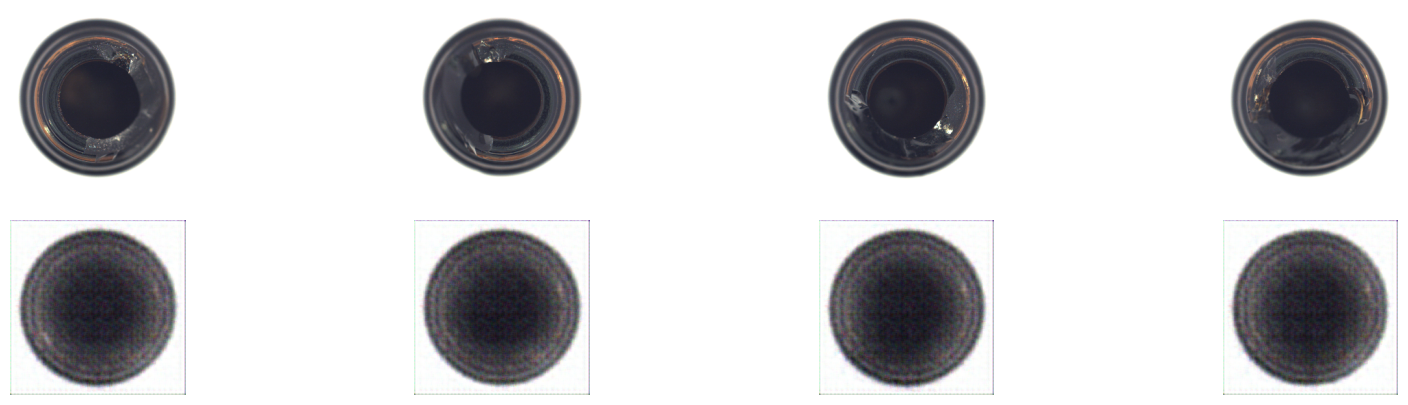

In [25]:
# Plotting original and reconstructed images
fig, axes = plt.subplots(2, 4, figsize=(20, 5))
for i in range(4):
    axes[0, i].imshow(images[i].cpu().permute(1, 2, 0))
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructions[i].cpu().permute(1, 2, 0))
    axes[1, i].axis('off')
plt.show()